In [27]:
import torchvision, torch
from torchvision import transforms

image_path = ''

transform = transforms.Compose([
    transforms.ToTensor(), # cvt to tensor and normalize in [0.,1.]
])

mnist_dataset = torchvision.datasets.MNIST(root=image_path,
                                           train=True,
                                           transform=transform,
                                           download=True)

from torch.utils.data import Subset

# class labels are randomly distributed so we can take subsequences
mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000)) # take first 10k for validation
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset))) 
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path, train=False, transform=transform, download=False)

In [28]:
from torch.utils.data import DataLoader

batch_size = 64
torch.manual_seed(0)
train_dataloader = DataLoader(mnist_train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(mnist_valid_dataset, batch_size=batch_size, shuffle=False)

In [29]:
import torch.nn as nn

model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2, stride=2))
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2, stride=2))

In [30]:
# check dimensions of feature maps (example: batch size 4)
x = torch.ones((4, 1, 28, 28))
model(x).shape
# the output will be batch: 4, channels: 64, WxH: 7x7

torch.Size([4, 64, 7, 7])

In [31]:
# now fully connected layers on top of the convolutional and poolings
# this one requires rank 2: [batch size x input units]
model.add_module('flatten', nn.Flatten())
model(x).shape
# 3136 = 64*7*7

torch.Size([4, 3136])

In [32]:
model.add_module('fc1', nn.Linear(in_features=64*7*7, out_features=7*7))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))
model.add_module('fc2', nn.Linear(in_features=7*7, out_features=10))

In [33]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda:0")
model = model.to(device) 

In [34]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    acc_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    acc_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train() # set training mode
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            pred = model(x_batch)
            loss = loss_function(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = torch.argmax(pred, dim=-1) == y_batch
            is_correct = is_correct.float()
            acc_hist_train[epoch] += is_correct.sum().cpu().item()
        loss_hist_train[epoch] /= len(train_dl.dataset)
        acc_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)
                loss = loss_function(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
                acc_hist_valid[epoch] += is_correct.sum().cpu().item()
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        acc_hist_valid[epoch] /= len(valid_dl.dataset)
    
        print(f'Epoch {epoch+1}, training accuracy: {acc_hist_train[epoch]:.4f}, validation accuracy: {acc_hist_valid[epoch]:.4f}')
    
    return loss_hist_train, loss_hist_valid, acc_hist_train, acc_hist_valid

In [35]:
torch.manual_seed(0)
num_epochs = 20
hist = train(model, num_epochs, train_dataloader, valid_dataloader)

Epoch 1, training accuracy: 0.8675, validation accuracy: 0.9774
Epoch 2, training accuracy: 0.9484, validation accuracy: 0.9831
Epoch 3, training accuracy: 0.9584, validation accuracy: 0.9862
Epoch 4, training accuracy: 0.9632, validation accuracy: 0.9863
Epoch 5, training accuracy: 0.9680, validation accuracy: 0.9884
Epoch 6, training accuracy: 0.9720, validation accuracy: 0.9892
Epoch 7, training accuracy: 0.9763, validation accuracy: 0.9899
Epoch 8, training accuracy: 0.9795, validation accuracy: 0.9882
Epoch 9, training accuracy: 0.9808, validation accuracy: 0.9887
Epoch 10, training accuracy: 0.9827, validation accuracy: 0.9900
Epoch 11, training accuracy: 0.9832, validation accuracy: 0.9902
Epoch 12, training accuracy: 0.9842, validation accuracy: 0.9905
Epoch 13, training accuracy: 0.9855, validation accuracy: 0.9898
Epoch 14, training accuracy: 0.9862, validation accuracy: 0.9902
Epoch 15, training accuracy: 0.9873, validation accuracy: 0.9912
Epoch 16, training accuracy: 0.987

### The better performance on the validation set may be due to dropout not being applied during evaluation (`model.eval()`), which allows the model to perform more robustly.

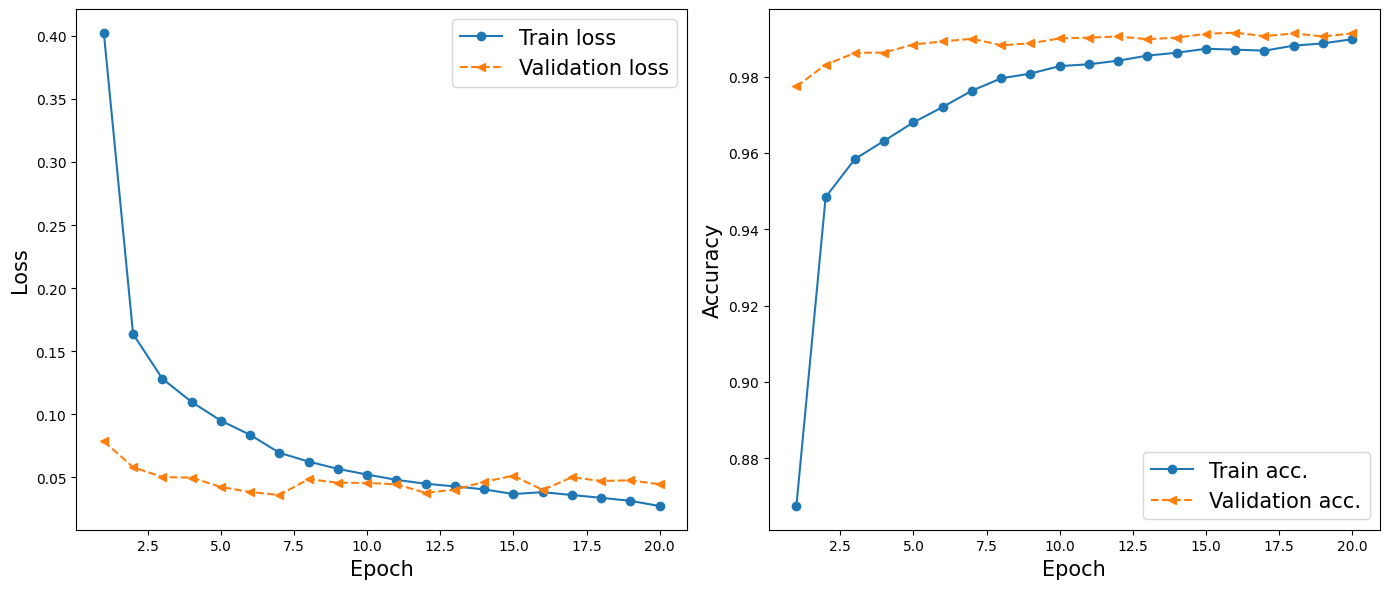

In [36]:
import matplotlib.pyplot as plt
import numpy as np

x_arr = np.arange(len(hist[0])) + 1

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(14, 6))
ax[0].plot(x_arr, hist[0], '-o', label='Train loss')
ax[0].plot(x_arr, hist[1], '--<', label='Validation loss')
ax[0].set_xlabel('Epoch', size=15)
ax[0].set_ylabel('Loss', size=15)
ax[0].legend(fontsize=15)

ax[1].plot(x_arr, hist[2], '-o', label='Train acc.')
ax[1].plot(x_arr, hist[3], '--<', label='Validation acc.')
ax[1].legend(fontsize=15)
ax[1].set_xlabel('Epoch', size=15)
ax[1].set_ylabel('Accuracy', size=15)

plt.tight_layout()

In [68]:
torch.cuda.synchronize()
model_cpu = model.cpu()
model_cpu.eval()

with torch.no_grad():
    test_pred = model_cpu(mnist_test_dataset.data.unsqueeze(1) / 255.)
    
is_correct = (torch.argmax(test_pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}')

Test accuracy: 0.9926


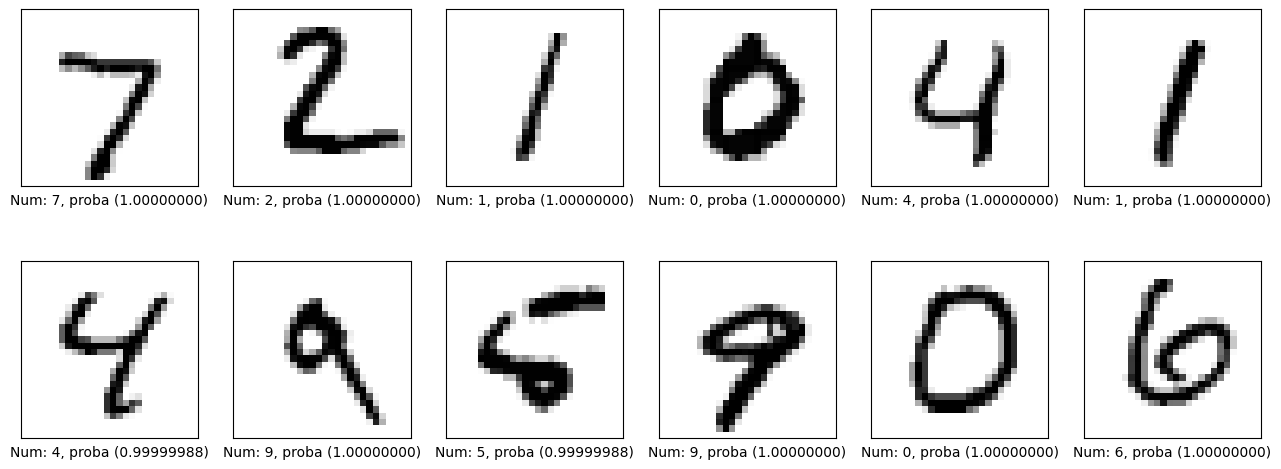

In [67]:
import torch.nn.functional as F
fig = plt.figure(figsize=(16, 6))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = mnist_test_dataset[i][0][0, :, :]
    pred_logits = model(img.unsqueeze(0).unsqueeze(1))
    pred_probs = F.softmax(pred_logits, dim=1)
    y_pred = torch.argmax(pred_probs)
    prob = pred_probs[0, y_pred].item()
    ax.imshow(img, cmap='gray_r')
    ax.text(0.5, -0.1, f'Num: {y_pred.item()}, proba ({prob:.8f})', 
            size=10, color='black',
            horizontalalignment='center',
            transform=ax.transAxes)
    
plt.show()

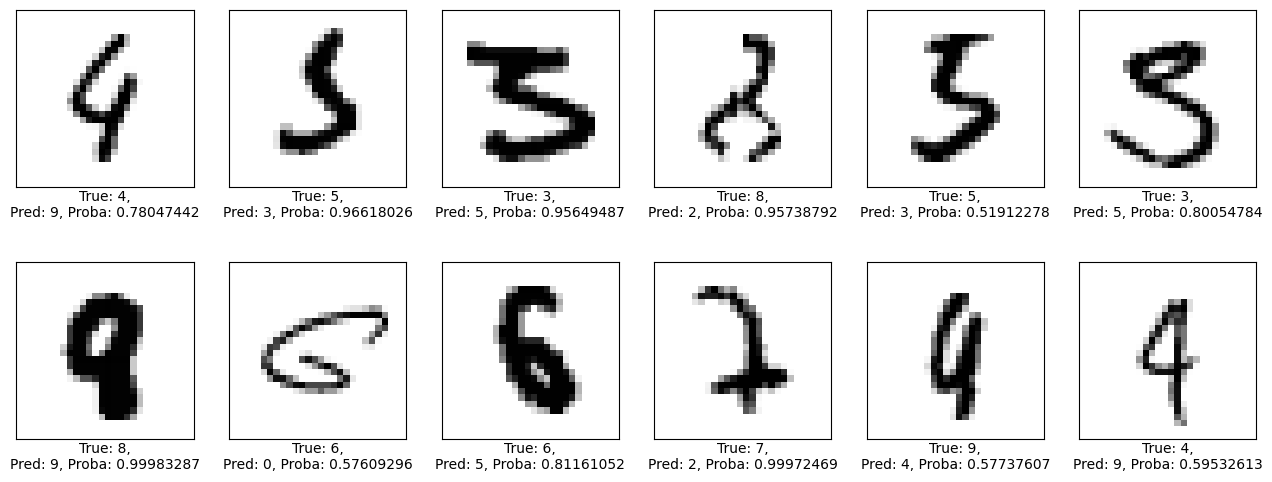

In [73]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Find indices where predictions are incorrect
misclassified_indices = (torch.argmax(test_pred, dim=1) != mnist_test_dataset.targets).nonzero(as_tuple=True)[0]

# Plot misclassified examples
fig = plt.figure(figsize=(16, 6))
for i in range(min(12, len(misclassified_indices))):
    idx = misclassified_indices[i]
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = mnist_test_dataset.data[idx].float() / 255.  # No need for unsqueeze(0)
    true_label = mnist_test_dataset.targets[idx].item()
    pred_logits = test_pred[idx].unsqueeze(0)  # Remove extra unsqueeze
    pred_probs = F.softmax(pred_logits, dim=1)
    y_pred = torch.argmax(pred_probs, dim=1).item()
    prob = pred_probs[0, y_pred].item()
    ax.imshow(img, cmap='gray_r')
    ax.text(0.5, -0.17, f'True: {true_label},\nPred: {y_pred}, Proba: {prob:.8f}', 
            size=10, color='black',
            horizontalalignment='center',
            transform=ax.transAxes)

plt.show()